# Postprocessing Segmentation
Ilastik outputs a probability mask that assigns a probability for each pixel that it either belongs to foreground (cell) or background.
We now need to convert this to a proper segmentation.

> **Exercise**  
>  
> Think about the steps needed to convert a probability map to a segmentation.

## Import packages

Before starting the code we need to import all the required packages.

We use a number of important Python packages:
- [Numpy](https://numpy.org): Go to package for vector/matrix based calculations (heavily inspired by Matlab)
- [Pandas](https://pandas.pydata.org): Go to package for handling data tables (heavily inspired by R) 
- [Scipy](https://scipy.org): Numpy extensions for statistics, image analysis, and more
- [Scikit-image (skimage)](https://scikit-image.org): Go to package for image analysis
- [Matplotlib](https://matplotlib.org): Go to package for plotting data
- [Seaborn](https://seaborn.pydata.org): Fancy plots made easy (Similar to ggplot in R)
- [Napari](https://napari.org): GUI based interactive image viewer
- [Dask-Image](https://image.dask.org/en/latest/): Out-of-memory computation made easy
- [pathlib](https://docs.python.org/3/library/pathlib.html): Path handling made easy
- [h5py](https://www.h5py.org): Read HDF5 file format

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#next line is required for Napari
%gui qt

#main data analysis packages
import numpy as np
import pandas as pd

#image processing packages
from scipy import ndimage as ndi
import skimage.segmentation as segmentation 
import skimage.filters as filters
from skimage.measure import label, regionprops, regionprops_table
from skimage import morphology

#data plotting packages
import matplotlib
import matplotlib.pyplot as plt
#set default figure size
matplotlib.rc("figure", figsize=(10,5))
import seaborn as sns

#image viewer
import napari
from napari.utils.notebook_display import nbscreenshot

#out of memory computation
from dask_image.imread import imread
import dask.array as da

#path handling
import pathlib

#file handling
import h5py

#Instead of dask_image.imread.imread() you can also use tifffile.imread() to directly read images into memory
#import tifffile

In [2]:
#we initiate a cashe for Dask to speed up repeated computation (important for working with Napari)
from dask.cache import Cache
cache = Cache(2e9)  # Leverage two gigabytes of memory
cache.register()    # Turn cache on globally

## Import and visualize segmentation
### Load images
First we import and visualize the image data using Napari. 

If you followed our filename convention the code below should work. If you get an error check your path and filenames and adept them in the code below.

In [3]:
#Set the path to the folder that contains project data
#pathlib.Path.home() return the location of your home folder in a platform independent way. 
root = pathlib.Path(pathlib.Path.home(), 
                    'I2ICourse/Project2A/ProcessedData/')

image_name = 'pos0_preproc-rg.tif' #set name of image
segment_name = 'pos0_preproc-rg_Probabilities.h5' #set name of segmented data
n_channel = 2 #set number of color channels in image
fg_idx = 0 #set index of foreground label used in Ilastik

im_path = root / image_name 
print('path to image: ', im_path)

path to image:  /Users/simonvanvliet/I2ICourse/Project2A/ProcessedData/pos0_preproc-rg.tif


Time-lapse images can be big, and can easily overload your memory. To make sure this does not happen, you can use "out of memory" computation, where only the data that is directly needed is loaded into memory (e.g. the current time point). This is slower then loading the full dataset into memory, but it scales well when data gets too big to do that. Out-of-memory computation is quite easy with the use of [Dask image](https://image.dask.org/en/latest/). We will use this below.

Don't worry about the technical details, though if you are curious we provide some optional 'Technical Notes' below: 

In [4]:
# you can use tifffile.imread to read complete image stack into memory.
#im_stack = tifffile.imread(im_path) #load image into memory

# or dask_image imread to use out of memory processing
im_stack = imread(im_path) #load image with dask-image for out of memory processing 

# dask_image imread creates a 3D stack, where both color channels are interweaved
# to separate them we need to reshape to 4D stack
if n_channel>1: 
    newshape = (int(im_stack.shape[0]/n_channel), n_channel, *im_stack.shape[1:])
    im_stack = im_stack.reshape(newshape)


To visualize the data we will use [Napari](https://napari.org), that allows for interactive image visualisation. 
We will first load the raw data. Use the slider at the bottom to scroll trough time. 

*(Technical note: Napari and Dask work very well together, every time you move the time slider, Dask loads the corresponding image into memory.)*

In [5]:
#setup napari viewer, with 2 channel image
viewer = napari.view_image(im_stack,
            channel_axis=1,
            name=["red", "green"],
            colormap=["yellow", "blue"],)
napari.run()

### Load and visualize Ilastik output
Next we load the data exported by Ilastik.

`h5py.File=()` loads a dictionary, which contains a single entry called `exported_data`.   
This contains the Ilastik probability output as an array of shape (t,label,y,x).  
We only need the probability that a pixel belongs to the foreground label (= cells), so we extract the corresponding layer.

Then we add the probability map to the Napari Viewer.
You can change the opacity and layer order to improve visualization.

In [6]:
seg_path = root / segment_name #path to Ilastik output
seg_data = h5py.File(seg_path, 'r') #open 
print('keys = ', list(seg_data.keys()))

#we again use Dask to load the data out of memory
#technical comment: we set chunk size to be equal to the size of single frame. 
chuck_size = (1, *im_stack.shape[-2:]) if n_channel==1 else (1, n_channel, *im_stack.shape[-2:])
seg_cell = da.from_array(seg_data['exported_data'], chunks=chuck_size)

#we get a segmentation probability for both labels (cells and BG) but only need the one for the cells, so we extract the correct dimension:
seg_cell = seg_cell[:,fg_idx,:,:]

#add probability layer to Napari Viewer
prop_layer = viewer.add_image(seg_cell, name='probability',colormap='gray')

keys =  ['exported_data']


> **Exercise** 
>   
> Check the segmentation quality. How well did it work? Are there frames with big problems?
>   
> If needed, you can go back to Ilastik and add extra training points in problem areas (check with Tutor).

## Convert Ilastik probability map into segmentation
Ilastik assigns to each pixel the probability that it belongs to a cell. We need to convert this to in instance based segmentation, where each cell is assigned a unique label. This requires a number of steps:
1. Pre-process probability map using filters
2. Convert probability map to semantic segmentation (binary image where cells=1 and background=0) using thresholding
3. Clean up semantic segmentation using morphological operations
4. Convert semantic segmentation into instance segmentation (integer images where each cells has own label)
5. Post-process instance segmentation by separating merged cells using watershed algorithm

### Pre-process probability map using filters
As a first step probability maps are often processed using a Gaussian blur filter using a small (~1 pixel) size, to ensure that the probability maps are locally smooth. We will use scikit image [`filters.gaussion`](https://scikit-image.org/docs/stable/api/skimage.filters.html) to do this. 

*(Technical note: scikit images does not automatically play nice with Dask's out of memory processing, instead we need to manually specify that we want to run `filters.gaussion` on each chunk (i.e. each frame) of our `seg_cell` image stack. This we can do using the Dask Image [`map_blocks()` function](https://docs.dask.org/en/latest/generated/dask.array.map_blocks.html))*.

*The usage is pretty straightforward, if normally you would use: `name_of_function_to_apply(normal_array, other_function_arguments)` you can now use: `da.map_blocks(name_of_function_to_apply, dask_array, other_function_arguments)`*

In [7]:
sigma = 1 #size of Gaussion kernel to use 

#this is how you normally use scikit filters.gaussian
#seg_cell_sm = filters.gaussian(seg_cell, sigma, channel_axis=0) 

#this is how we do it using Dask:
seg_cell_sm = da.map_blocks(filters.gaussian, seg_cell, sigma, channel_axis=0)

#add to viewer
prop_layer_sm = viewer.add_image(seg_cell_sm, name='probability smoothed',colormap='gray')


### Create semantic segmentation by thresholding probability map

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to convert continues probability maps into binary label images. It is a first step in segmenting objects. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker.

There are automatic methods to calculate a threshold, e.g. Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. However, often a manually chosen thresholds works best, and we will use that here.  

In [8]:
#create array with all threshold values to rry, here we use 0,0.01,0.02,...,1
thresholds_to_try = np.linspace(0,1,101)

#apply treshold, loop over all threshold values and store output in list
all_thresholds = [seg_cell_sm>t for t in thresholds_to_try]

#convert the list of 3D stacks to a single 4D stack
threshold_stack = da.stack(all_thresholds, axis=0)

#add to viewer
mask_layer_int = viewer.add_image(threshold_stack, name='binary mask int',colormap='gray')

In the Napari viewer you will now have a new layer `binary mask int`, which shows you the result of the interactive thresholding, you can change the threshold value by moving the new slider (channel 0).

> **Exercise** 
>  
> Move the slider to find a good threshold value. How does it compare to the one calculated by the algorithms above? 
> 
> Hint: the slider position shows the index in the `thresholds_to_try`

Note: if at any time you want to store the current view shown in the Napari viewer, then you can use `nbscreenshot(viewer)`.

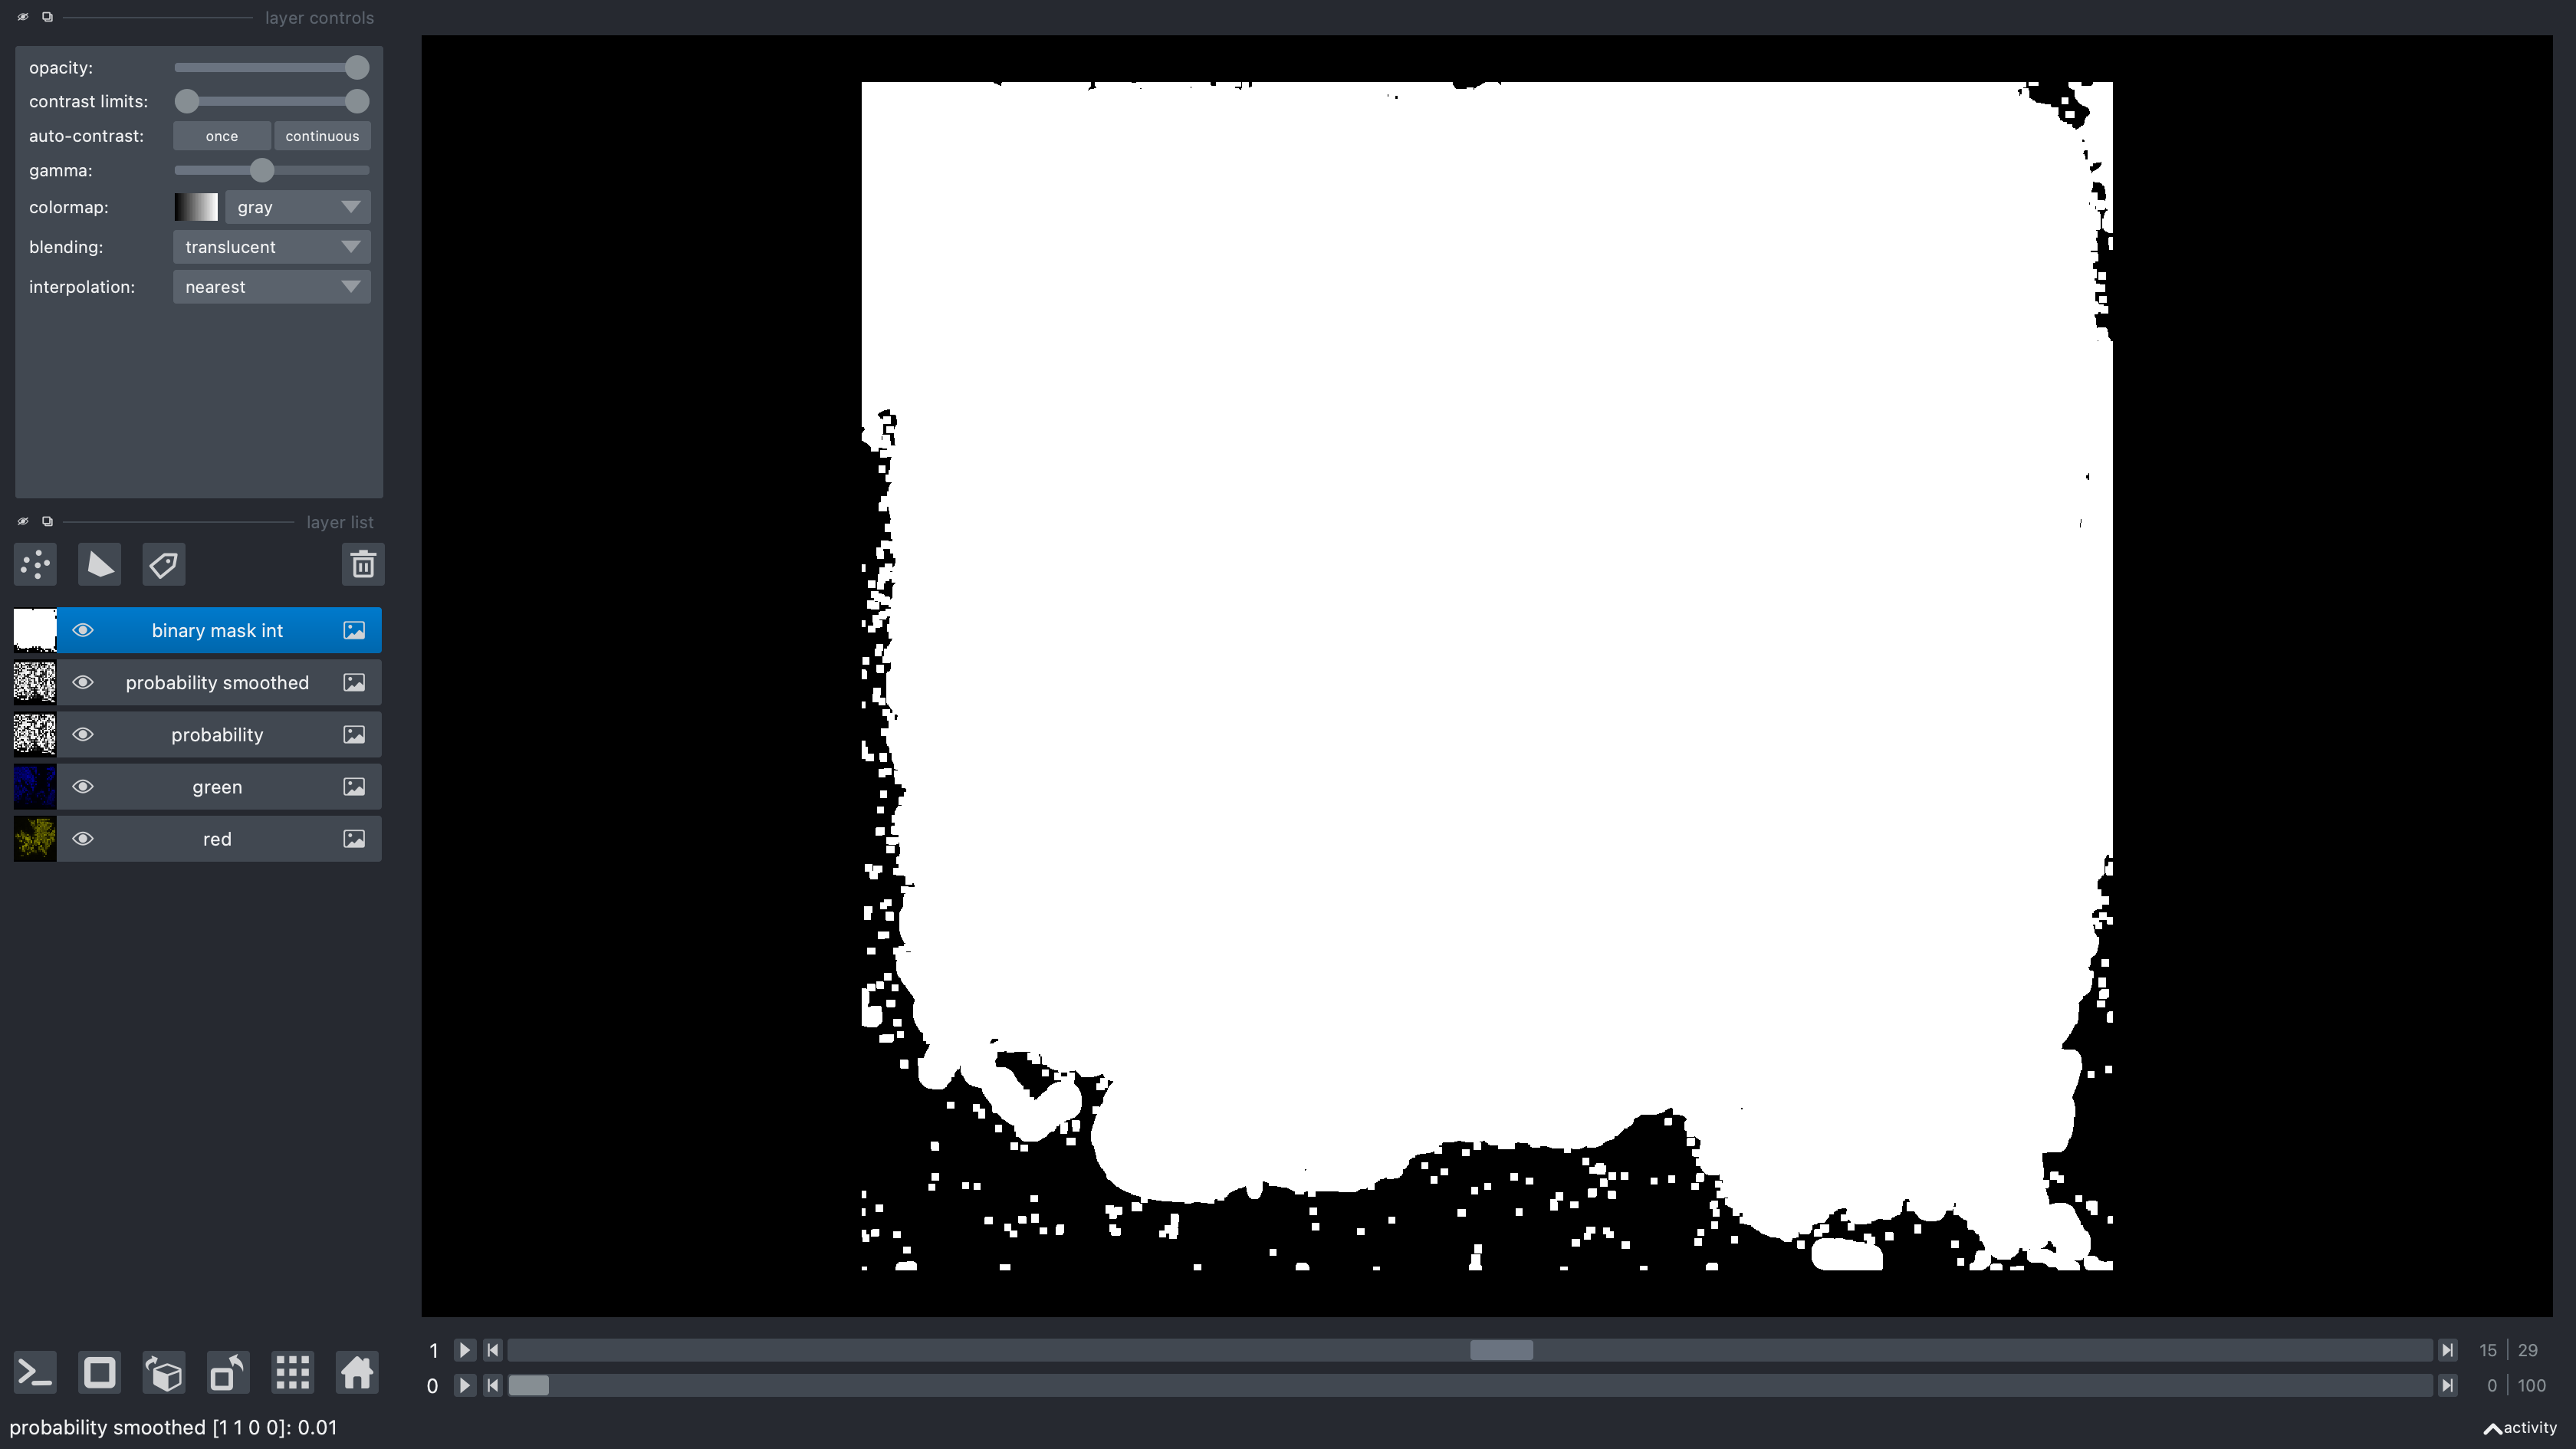

In [9]:
nbscreenshot(viewer)

> **Exercise** 
> 
> Now it is time to choose a final threshold value. Enter the value you have chosen below.

In [10]:
#choose your favorite method or enter a manually chosen value
final_threshold = 0.66

#threshold and add to viewer
bin_mask = seg_cell_sm > final_threshold
mask_layer_final = viewer.add_image(bin_mask, name='final binary mask',colormap='gray')

We can now remove the interactive threshold layer from the viewer.

In [11]:
viewer.layers.remove("binary mask int")

### Clean up semantic segmentation using morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a size parameter, which is the minimum size (in pixels) of accepted holes or objects.

> **Exercise**
>
> Try finding good values for `max_hole_size` and `min_cell_size`, by changing the parameters below.

*(Technical note `skimage.morphology` only works on 2D/3D image data, not on time stacks, we thus have to apply it to each frame separately, luckily `da.map_blocks()` can take care of that for us)*

In [12]:
max_hole_size = 40 # maximum area of holes that will be filled (in pixels)
min_cell_size = 150 # minimum area of objects to keep (in pixels)

holes_removed = da.map_blocks(morphology.remove_small_holes, bin_mask, max_hole_size)
bin_mask_clean = da.map_blocks(morphology.remove_small_objects, holes_removed, min_cell_size)

mask_layer_clean = viewer.add_image(bin_mask_clean, name='binary mask cleaned',colormap='gray')

### Convert semantic segmentation into instance segmentation 

Now we are ready to label the connected components of this image. This means that each object will be assigned a unique number. For this we can use the [`skimage.measure.labels()`](https://scikit-image.org/docs/dev/api/skimage.measure.html) function.
To add labels to Napari, we can use the `add_label()` function.

You can change the colors assigned to cells, using the shuffle button in upper left corner. 

In [13]:
#again we will need to loop over the time using map_blocks
label_im = da.map_blocks(label, bin_mask_clean)
label_layer = viewer.add_labels(label_im, opacity=0.5)

> **Exercise**
> 
> Inspect the segmentation. Do you find any problems? Think about what we need to do next.

### Post-process instance segmentation by separating merged cells using watershed algorithm

We can see that tightly packed cells connected in the binary image are assigned the same label.

A better segmentation would assign different labels to different cells. 

Typically we use [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) for this purpose. This requires two steps: 1) using a so-called [distance transform](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html) we  calculate the distance of each pixel to the object boundary 2) we need to find center points (called *markers*) for each object. We place *markers* at the centre of each object, and these labels are expanded until they meet an edge or an adjacent marker.

The trick, then, is how to find these markers. For spherical cells, there is a commonly used strategy that works quite well: we can simply find the local maxima of the distance transform (we provide the code for this below for reference).

For rod shape cells, this works quite badly, though. Another way to find cell centers is by using a very high threshold for the probability map, as probabilities are typically  highest in the cell centre. Then we can use these regions as markers for the watershed.

In [14]:
#set threshold to use to find cell centers
center_threshold = 0.95

center_seg = seg_cell_sm > center_threshold
center_markers = da.map_blocks(label, center_seg)
    
centre_layer = viewer.add_labels(center_markers, name='cell centre areas')   

> **Exercise**
> 
> Find a good value to use for `center_threshold` such that nearby cells have different center markers (without chopping cells into parts). Spend max 5 min on this! 

Once we have the center points we can further segment the image by using the watershed, we calculate the distance using [scipy.ndimage.morphology.distance_transform_edt](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html) and then apply the watershed using [`skimage.segmentation.watershed`](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed):

In [15]:
#we need a wrapper function to tranform named arguments into positional arguments to make things work with Dask
def watershed(dist, markers, mask):
    return segmentation.watershed(-dist, markers=markers, mask=mask)    

In [16]:
#calculate distance to edge of mask
dist_transform = da.map_blocks(ndi.distance_transform_edt, bin_mask_clean)   

#run watershed
labels_final = da.map_blocks(watershed, -dist_transform, center_markers, bin_mask_clean, chunks=(1,*bin_mask_clean.shape[-2:]))

#add to Napari
watershed_layer = viewer.add_labels(labels_final, name='after watershed')   

The watershed should have cut clusters of cells apart, improving the segmentation by separating nearby cells.

However, you might also have seen some cells that were cut but should not have. There are several things you could do here to improve things

- Improve segmentation
  - The better quality the input data has, the easier and better the post-processing will be 
  - In many cases the fastest solution will be to return to Ilastik and add some training points in problem regions
- Use 3 classes to segment your image (cell centre / cell edge / background)
  - You can then calculate distance transform on cell edge data
  - More over you can use `skimage.future.graph.rag.rag_boundary` and `skimage.future.graph.merge_hierarchical()` to merge objects back together 

For time reasons we will skip these steps now, but we can come back to them at the end of the course if time allows it. 

*Aside: Code to find markers for watershed algorithm for spherical cells*

```python
from skimage.feature import peak_local_max

#calculate distance to edge of mask
dist_transform = da.map_blocks(ndi.distance_transform_edt, bin_mask_clean)   

#add to Napari 
dist_layer = viewer.add_image(dist_transform, name='distance transform',colormap='viridis')  

#min distance between maxima, adjust this value to slightly less than 2x the radius of the smallest cells.
min_distance = 10


#initialize empty array of right size
markers_list = np.empty((3,0))

#find maxima in distance transform
for t, dist_map in enumerate(dist_transform):
    #dist_map = filters.gaussian(dist_map, 2) 
    peak_idx = peak_local_max(dist_map.compute(), min_distance=min_distance)
    peak_idx_3d = np.insert(peak_idx.T,0,t,axis=0)
    markers_list = np.concatenate((markers_list,peak_idx_3d),axis=1)
    
#add to Napari Viewer
point_layer = viewer.add_points(
    np.transpose(markers_list),
    name='center points',
    size=4,
    n_dimensional=False)
```

### Storing data

Segmentation can be a time-consuming process so you might want to store the output on your HD. 
Here we store it as HDF5 for fast access from Python.

In [62]:
#we can first convert to 16bit to save some space
labels_final.astype('int16')

#store as hdf5
seg_name_hdf5 = root /  image_name.replace('.tif','_label_im.hdf5')
labels_final.to_hdf5(seg_name_hdf5, '/labels_final')

### Loading data
To load the segmentation again we can use:

In [70]:
label_data = h5py.File(seg_name_hdf5, 'r') #open 
labels_final_loaded = da.from_array(label_data['labels_final'], chunks=(1,-1,-1))


## Measuring Cell Properties

Now that we have our final segmentation, we can make measurements on them using `skimage.measure.regionprops` and `skimage.measure.regionprops_table`. These measurements include features such as area or volume, bounding boxes, and intensity statistics.

### Using Regionprops to extract cell properties
`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. Note that color axis needs to be at the end!

We demonstrate it's usage here by analyzing the first frame.

In [73]:
#extract first frame
label_im = labels_final[0,:,:]
image = im_stack[0,:,:]

#region props need color channel to be at end
image = np.moveaxis(image, 0, -1)
#we add the .compute() to instruct Dask to do all the calculations at this stage
reg_props = regionprops(label_im.compute(), intensity_image=image.compute())
    
print(len(reg_props))
reg_props[0] 

981


`reg_props` is a list containing the region properties of all cells present at this time. A list of all propertied can be found in the [scikit-image documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops).

We can thus extract a property using `rep_props[c].[property_name]`, where `c` indicates the cell label nr.  

We can for example extract the mean intensity of the cell:

In [78]:
print('cell mean intensity = ', reg_props[0].intensity_mean)

cell mean intensity =  [ 151.36526316 1226.18315789]


But we can also extract more complex info, such as the cell mask:

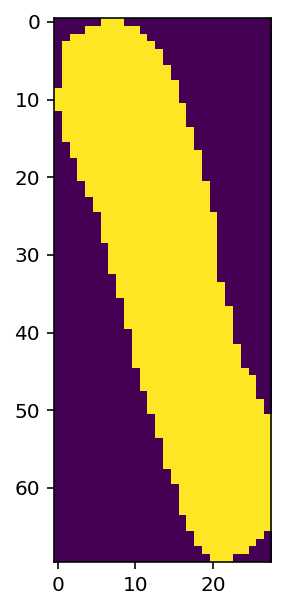

In [76]:
fig, axs = plt.subplots(figsize=(10,5))
axs.imshow(reg_props[0].image)

*(Technical aside: scikit-image 0.18 adds support for [passing custom functions](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for region properties as `extra_properties`.)*

### Using regionprops_table to extract cell measurements

`regionprops` returns a huge amount of info, but navigating it is a bit cumbersome.  
Instead you can use [`regionprops_table`](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops). It work in the same way, however, you will have to specify which properties you want to extract.

Here we will first look at a single frame:

In [80]:

#extract first frame
label_im = labels_final[0,:,:]
image = im_stack[0,:,:]
#region props need color channel to be at end
image = np.moveaxis(image, 0, -1)

#specify properties to extract 
prop_list = ['label', 
            'area', 'centroid', 
            'axis_major_length', 'axis_minor_length',
            'mean_intensity'] 

#get region prop table 
#we add the .compute() to instruct Dask to do all the calculations at this stage
rp_table = regionprops_table(label_im.compute(), intensity_image=image.compute(), properties=prop_list) 

### Create Pandas Dataframe for single time point
The output of the `regionprops_table` function can easily be converted in a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html), using the [`DataFrame`](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe) function. 

Pandas dataframes and R dataframes share a lot of features so if you are familiar with R you should hopefully feel right at home. For those coming from Matlab/Numpy it might take some time to get used to the Pandas syntax. Luckily there are very detailed guides available online, starting with the [Pandas Homepage](https://pandas.pydata.org).

In [81]:
info_table = pd.DataFrame(rp_table).set_index('label')

With `head()` we can have a look at the Pandas data frame:

In [87]:
info_table.head()

,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,aspect_ratio,frame
label,,,,,,,,,
1,950,73.262105,1420.313684,78.168638,16.040507,151.365263,1226.183158,4.873203,0
2,859,64.358556,1461.376019,76.139029,14.897100,138.108265,903.824214,5.110997,0
3,688,87.027616,1401.511628,62.098941,14.490098,173.408430,1072.390988,4.285612,0
4,756,85.839947,978.055556,57.380266,17.228570,158.706349,770.613757,3.330530,0
5,1740,87.659195,1121.195402,164.980811,17.285783,970.826437,158.549425,9.544307,0


### Extract cell properties for all time-points

So far we only analyzed a single frame, now let's combine them all. To do this it is helpful to define a function that processes a single time point and than call this for each time point. We the use `pandas.concat` to combine all time points into a single data frame.

In [88]:
#function to process single frame  
def extract_prop_slice(t, label_im, image, prop_list):
    #region props need color channel to be at end
    image = np.moveaxis(image, 0, -1)
    
    #get region prop table
    rp_table = regionprops_table(label_im.compute(), intensity_image=image.compute(), properties=prop_list) 
    df = pd.DataFrame(rp_table)
    
    #add the time index
    df["frame"] = t
    
    return df

In [98]:
#specify properties to extract 
prop_list = ['label', 
            'area', 'centroid', 
            'axis_major_length', 'axis_minor_length',
            'mean_intensity'] 

#loop over all frames
df_list = [extract_prop_slice(t, label, image, prop_list) for t, (label, image) in enumerate(zip(labels_final, im_stack))]

#combine into single dataframe
info_table_all = pd.concat(df_list)

In [92]:
#show start of dataframe
info_table_all.head()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame
0,1,950,73.262105,1420.313684,78.168638,16.040507,151.365263,1226.183158,0
1,2,859,64.358556,1461.376019,76.139029,14.897100,138.108265,903.824214,0
2,3,688,87.027616,1401.511628,62.098941,14.490098,173.408430,1072.390988,0
3,4,756,85.839947,978.055556,57.380266,17.228570,158.706349,770.613757,0
4,5,1740,87.659195,1121.195402,164.980811,17.285783,970.826437,158.549425,0


In [93]:
#show end of dataframe
info_table_all.tail()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame
1046,1048,505,1461.778218,1134.005941,37.137624,17.689999,358.273267,1016.233663,29
1047,1049,567,1458.740741,166.121693,50.422824,14.373229,534.398589,573.252205,29
1048,1050,701,1474.447932,176.750357,132.498904,7.226797,1573.671897,202.395150,29
1049,1051,462,1475.248918,313.272727,113.890276,5.376021,1435.028139,147.777056,29
1050,1052,14,1476.714286,251.500000,10.000000,1.807016,1195.785714,144.285714,29


## Working with Pandas Dataframes
Now let's analyze some data. You can manipulate Pandas data frames and e.g. extract a column.  
An extracted column is know as a [Series](https://pandas.pydata.org/docs/user_guide/dsintro.html#series).

In [100]:
cell_length = info_table_all['axis_major_length'] #extract a column 
print('data type of extracted column = ', type(cell_length))

data type of extracted column =  <class 'pandas.core.series.Series'>


You can also add new columns, either from a Series, Vector data, or constant value:

In [101]:
cell_length = info_table_all['axis_major_length'] #extract a column 
cell_width = info_table_all['axis_minor_length'] #extract a column 

#add new column based on ratio of two Series
info_table_all["aspect_ratio"] = cell_length/cell_width

#show output
info_table_all.head()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame,aspect_ratio
0,1,950,73.262105,1420.313684,78.168638,16.040507,151.365263,1226.183158,0,4.873203
1,2,859,64.358556,1461.376019,76.139029,14.897100,138.108265,903.824214,0,5.110997
2,3,688,87.027616,1401.511628,62.098941,14.490098,173.408430,1072.390988,0,4.285612
3,4,756,85.839947,978.055556,57.380266,17.228570,158.706349,770.613757,0,3.330530
4,5,1740,87.659195,1121.195402,164.980811,17.285783,970.826437,158.549425,0,9.544307


We can get a quick summary of the data using the [`describe` function](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html):

In [102]:
info_table_all.describe()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame,aspect_ratio
count,35009.000000,35009.000000,35009.000000,35009.000000,35009.000000,35009.000000,35009.000000,35009.000000,35009.000000,3.497500e+04
mean,592.240795,784.538347,632.318348,762.018557,68.911770,14.978334,631.103834,913.437313,14.088663,inf
std,347.248205,381.113552,377.308876,434.358290,32.289976,2.799770,605.354049,579.559100,8.541404,NaN
min,1.000000,1.000000,12.325424,23.292465,0.000000,0.000000,123.750000,129.000000,0.000000,1.000000e+00
25%,294.000000,553.000000,308.552133,379.978000,49.253616,13.480765,137.761780,256.202268,7.000000,3.263186e+00
50%,587.000000,711.000000,597.077425,740.532619,61.987130,14.909089,243.127580,1036.497041,14.000000,4.155263e+00
75%,881.000000,927.000000,943.547273,1152.694215,80.072031,16.536831,1205.758261,1404.735988,21.000000,5.530647e+00
max,1429.000000,7190.000000,1476.714286,1524.057592,613.809106,57.260113,3122.777997,2625.070175,29.000000,inf


We can also filter on rows and for example extract all cells that fulfill a certain requirement, for example we can sort out the largest 0.1% of cells using:

In [109]:
#find 99.9% percentile of cell lengths:
size_tr = info_table_all['axis_major_length'].quantile(0.999)

#select smallest cells:  
huge_cells = info_table_all[info_table_all['axis_major_length']>size_tr]
huge_cells.head(n=10)


,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame,aspect_ratio
931,932,6570,1402.949772,233.467580,429.083988,37.154564,1795.829833,207.469254,0,11.548621
3,4,4270,27.475176,1077.526230,393.851970,17.842443,1262.127166,158.546370,3,22.073881
1,2,4779,31.472275,1082.933250,456.156054,17.934894,1247.052940,170.166981,4,25.433998
0,1,4846,34.392695,1099.388568,465.917311,17.020571,1185.050970,167.508254,5,27.373777
2,3,4179,33.705193,1142.605647,415.714110,15.304794,1094.493898,166.851161,6,27.162346
1,2,4467,35.514663,1152.909559,439.350989,15.918305,1134.864786,183.023506,7,27.600363
1,2,4944,21.494134,1143.396845,508.002385,15.654690,1088.029531,189.208536,8,32.450492
1,2,4351,20.637325,1173.733165,450.751738,14.761825,986.396920,178.356700,9,30.534959
4,5,4116,16.528426,1183.999757,444.366328,14.078887,1034.379009,176.375364,11,31.562604
4,5,3895,21.027471,1204.685494,418.858990,14.357280,993.157381,183.630552,12,29.173979


For more details of how to use Pandas, see examples below or consult the extensive [documentation online](https://pandas.pydata.org/docs/user_guide/index.html)

## Plotting and analyzing cell properties using Pandas, Matplotlib, and Seaborn 

### Cell number over time
We will first look at how the number of cells changes over time.

We use the [`groupby`](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#splitting-an-object-into-groups) function on the `frame` property to group cells based on their frame. We can then count the number of cells at each frame by calling the `size()` property.

The result is a [Pandas Data Series](https://pandas.pydata.org/docs/user_guide/dsintro.html#series). We can directly plot the result using the build-in plot function.

<AxesSubplot:xlabel='frame', ylabel='# of cells'>

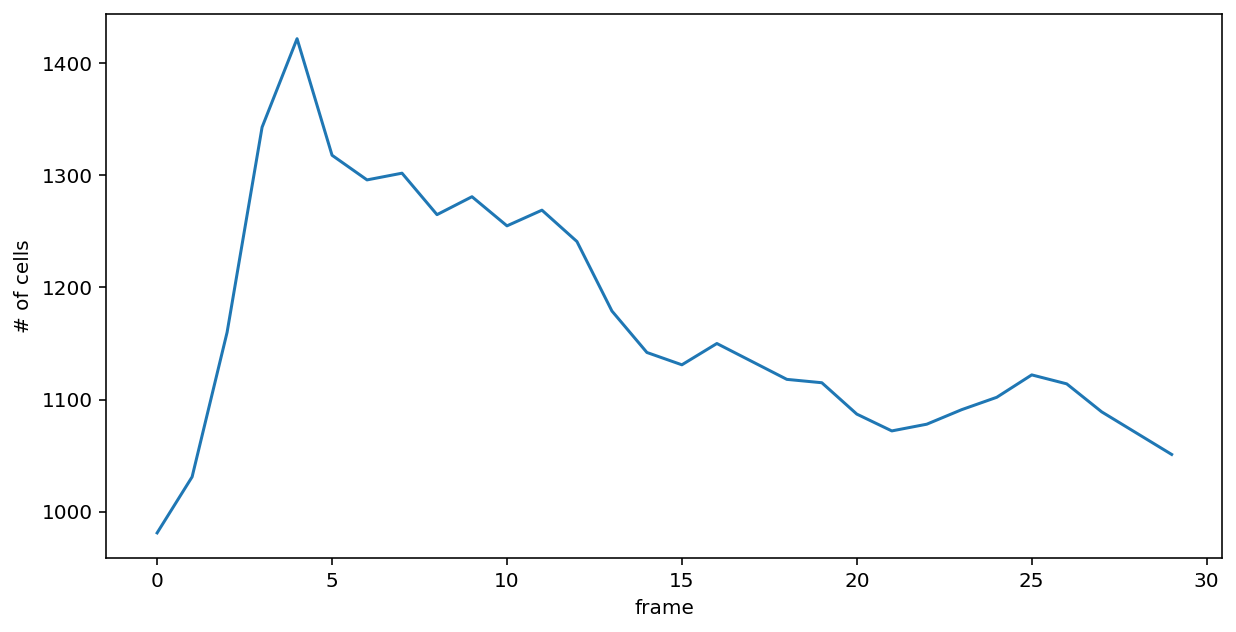

In [26]:
cell_num_t = info_table_all.groupby('frame').size() #output is pandas data series
cell_num_t.plot(xlabel='frame',ylabel='# of cells',figsize=(10,5)) #use build in plot function

### Average cell properties over time
Next we will look at how the average properties, such as their fluorescent intensity, of a cell changes over time.

Again we use the [`groupby`](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#splitting-an-object-into-groups) function on the `frame` property to group cells based on their frame. We can then calculate the average value for each group by calling the `mean()` function.

The output in this case is a Pandas dataframe. 


[Here](https://pbpython.com/groupby-agg.html) you can find an overview of how to group and aggregate data in Pandas.

The result is a [Pandas Data Series](https://pandas.pydata.org/docs/user_guide/dsintro.html#series). 

In [27]:
av_prop = info_table_all.groupby('frame').mean()
av_prop['frame'] = av_prop.index
av_prop.head()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame
frame,,,,,,,,,
0,491.000000,781.744139,761.812993,942.757719,65.906839,15.462280,432.533359,1006.273871,0
1,516.874879,766.479146,666.148824,882.643737,64.035481,15.483548,424.224212,1030.650997,1
2,581.631897,759.642241,658.026011,822.048494,65.221437,15.102125,400.289870,1056.955742,2
3,676.193596,727.594937,679.863313,793.823839,64.560940,14.548891,378.738352,1142.906333,3
4,716.386779,663.352321,668.796141,778.406594,58.411786,14.611676,412.827977,1280.988894,4


We can plot the result in two ways: using [Matplotlib](https://matplotlib.org/stable/index.html) or [seaborn](https://seaborn.pydata.org/index.html).

Matplotlib is a lower level package, giving you a lot of freedom but requiring quite ab it of code to make things look nice.

Seaborn is a higher level package, making it easier to make nice looking figures, at the cost of some flexibility.

First we show you Matplotlib:

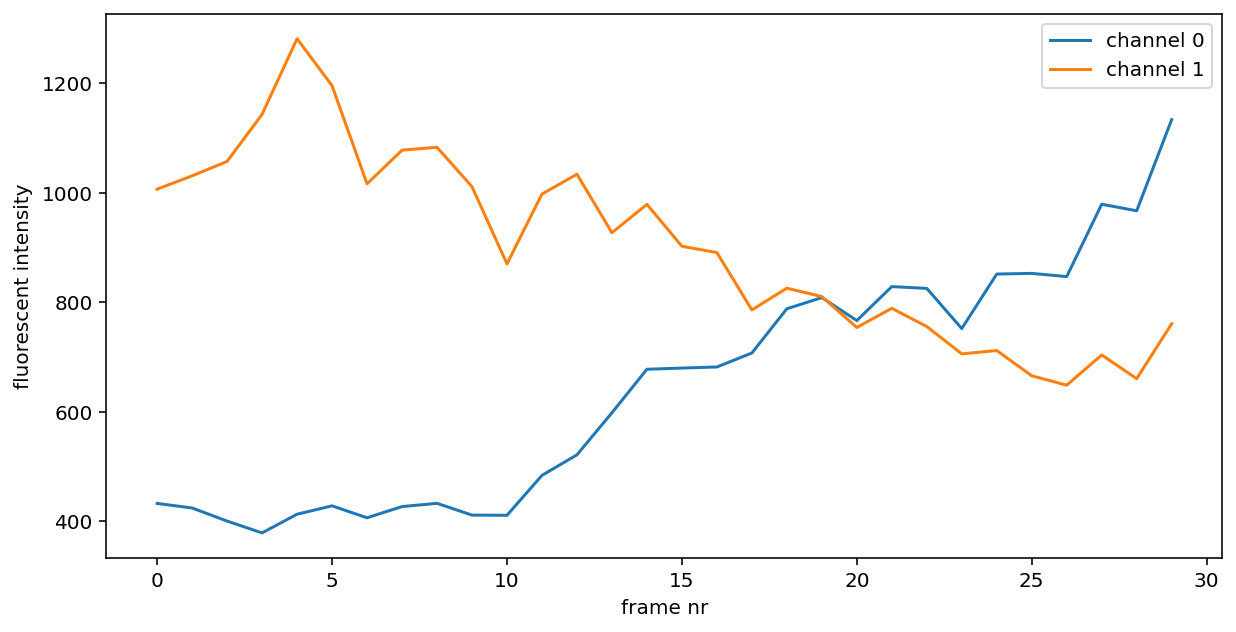

In [28]:
#plot with Matplotlib
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(av_prop['frame'],av_prop['mean_intensity-0'],label='channel 0')
ax.plot(av_prop['frame'],av_prop['mean_intensity-1'],label='channel 1')
ax.set_xlabel('frame nr')
ax.set_ylabel('fluorescent intensity')
ax.legend()

### Plotting with Seaborn

Now let's look at Seaborn:

Text(0, 0.5, 'fluorescent intensity')

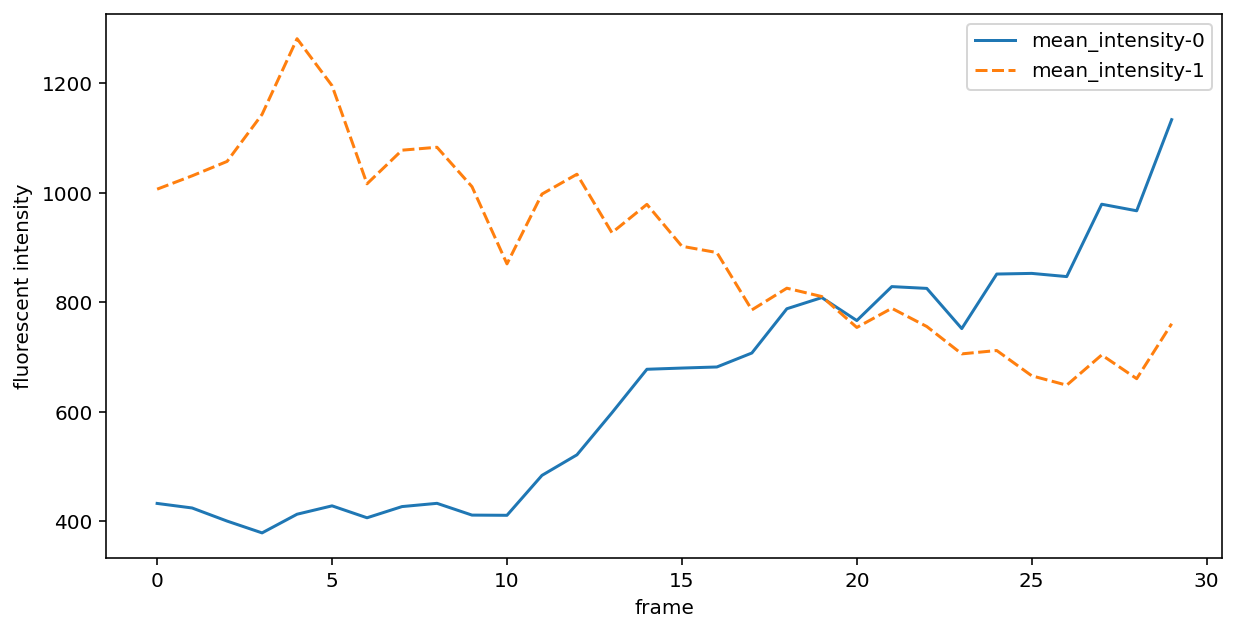

In [34]:
#plot with Seaborn
p = sns.lineplot(data=av_prop[["mean_intensity-0", "mean_intensity-1"]])
p.set_ylabel("fluorescent intensity")

Similarly we can look at distributions and scatter plots:

<AxesSubplot:xlabel='mean_intensity-0', ylabel='mean_intensity-1'>

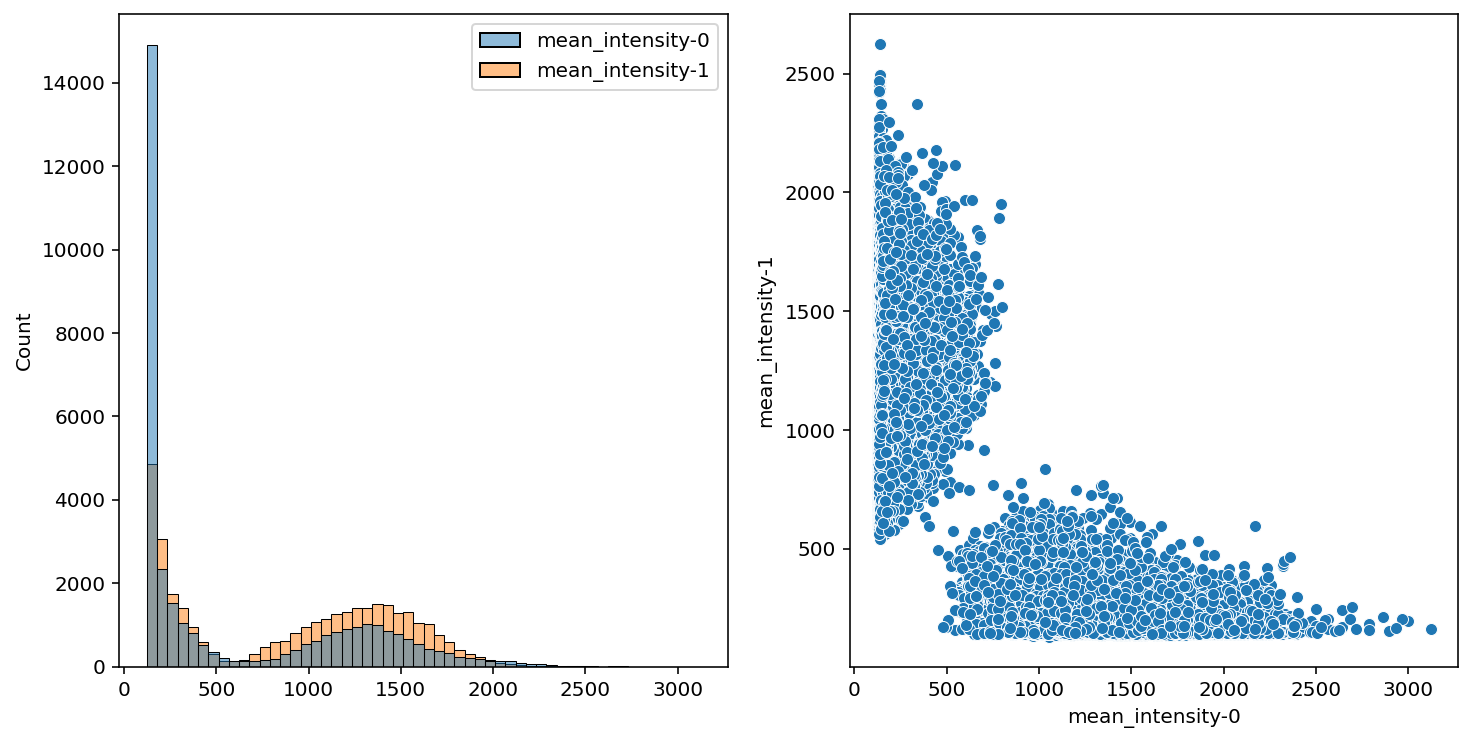

In [41]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(ax=axs[0], data=info_table_all[["mean_intensity-0", "mean_intensity-1"]])
sns.scatterplot(ax=axs[1], data=info_table_all, x="mean_intensity-0", y="mean_intensity-1")

Seaborn has also many mare advanced functionalities. For example you can automatically make a facet plot to make a separate plot for each group. Here we visualize how the distribution of RFP intensities changes over time:

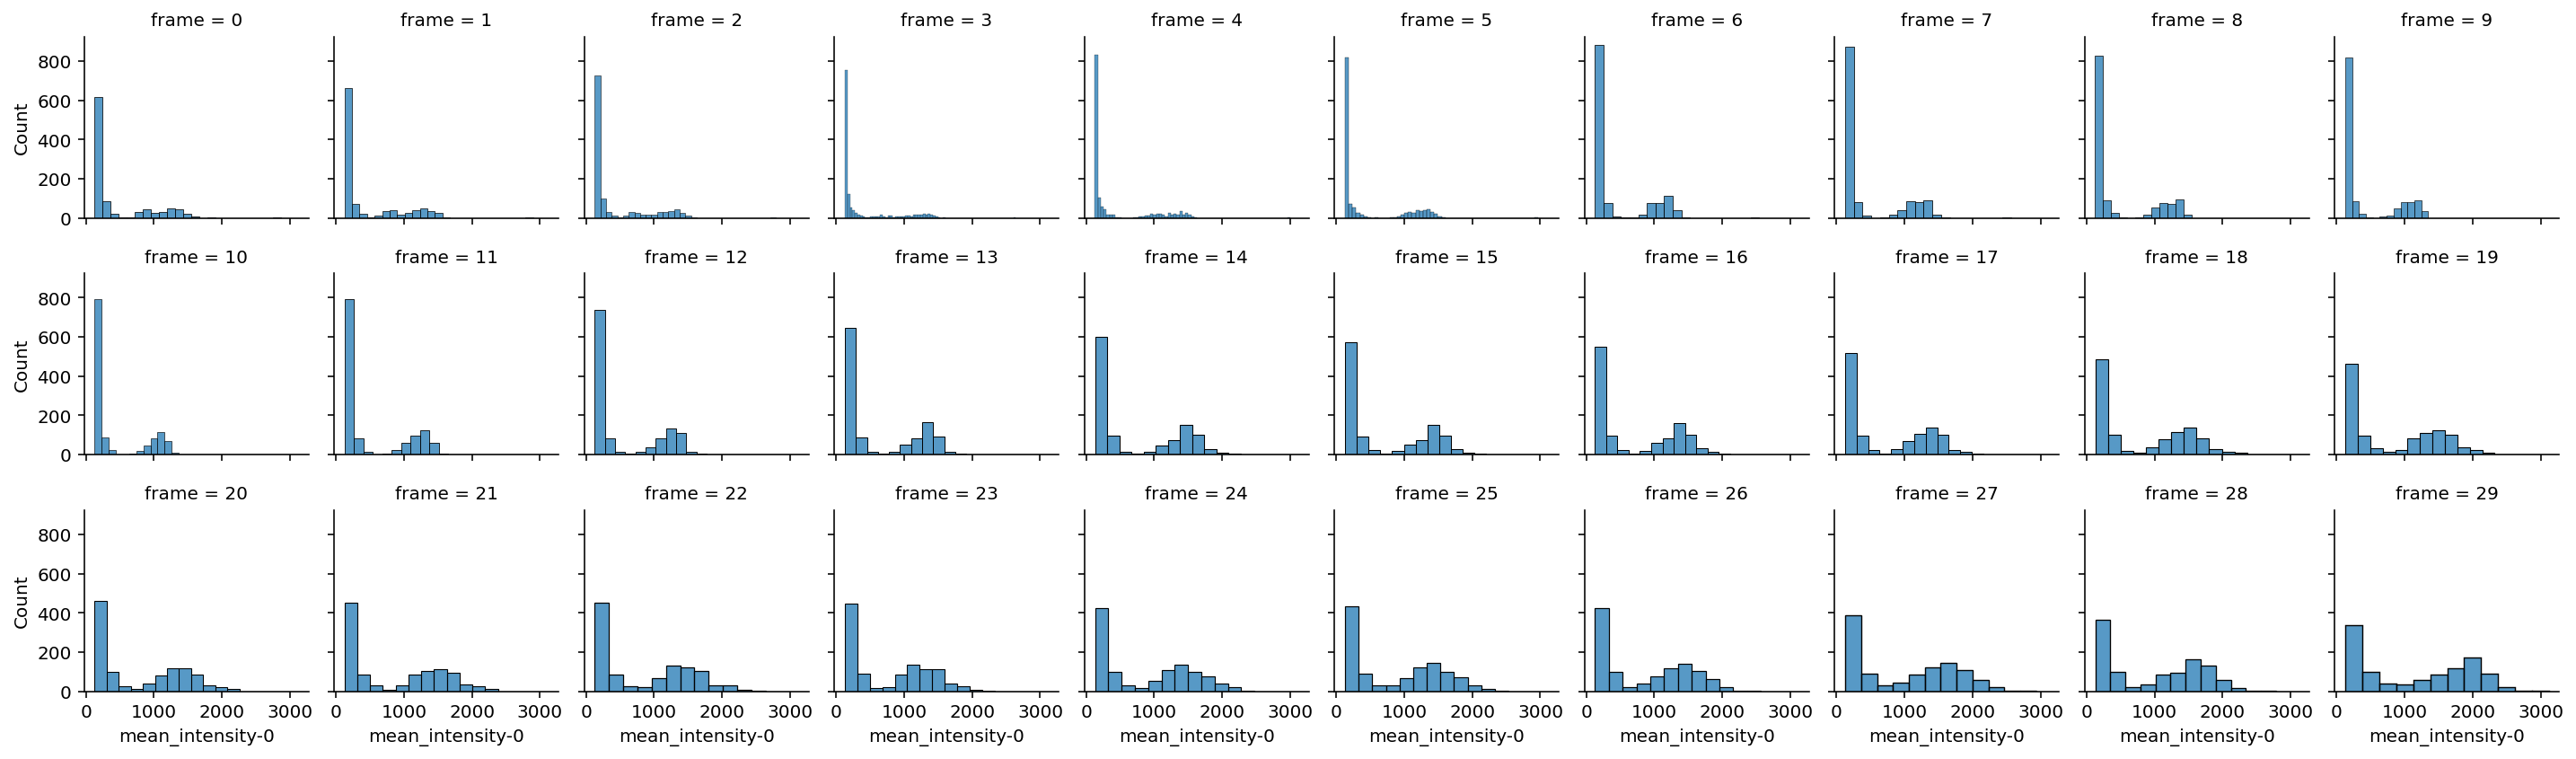

In [45]:
g = sns.FacetGrid(info_table_all, col="frame", col_wrap=10, height=2)
g.map(sns.histplot, "mean_intensity-0")

For more details, you can consult the [Example gallery](https://seaborn.pydata.org/examples/index.html) or [Tutorial section](https://seaborn.pydata.org/tutorial.html) on the Seaborn website.

## Time for some biology
The data we have been looking at is from a synthetic microbial cross-feeding community consisting of two auxotrophic strains of E. coli that can only grow by exchanging Amino-Acids with each other. We are interested in understanding the dynamics of this community, and as a first question we like to know how the frequency of the two cell types changes over time. It is now your task to try to answer this question.

> ## Exercise
> We are interested in the dynamics of the community, and would like to know how the fraction of red cells changes over time. Try to come up with a way to calculate this.
> 
> Hints:
> - Think about how you can tell red and green cells apart in a reliable way
> - Classify cells as either red or green
> - Calculate the fraction of red cells over time

In [29]:
#enter code here

### Solution 1
To see the solution, uncomment (remove `#`) the `load` line below and run the cell twice (first time will load the code second time will run it)

In [36]:
# %load ../Solutions/p0_classify_sol1.py

### Solution 2
To see the solution, uncomment (remove `#`) the `load` line below and run the cell twice (first time will load the code second time will run it)

In [37]:
# %load ../Solutions/p0_classify_sol2.py